# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks


#### Activity 1a: Implementing a Multilayer Fully Connected Network using Numpy
#### Non-graded activity (0 points)

- Objective

The primary objective of this activity is to deepen your understanding of Fully Connected Networks by implementing a multilayer network using only Numpy. You  are  given  the follosing starter code that solves the MNIST dataset problem. Your task is to read, understand, and then apply this knowledge to solve classification problems on other datasets such as the Kaggle ASL dataset (Starter code will be provided separately for that activity).

- Instructions

    Read and Understand the following Code: The provided starter code outlines the architecture of a Fully Connected Network designed to classify MNIST images. Go through the code to understand how each function and class is used to implement the network.

    Understand the Math: Make sure you understand the math operations implemented in the code, especially during the forward and backward passes. This will involve matrix multiplications, activation functions, loss computations, and backpropagation.
    
- Experiment
    You are encouraged to play with the code, change any hyperparameters and train the model, you should be able to achieve over 95% accuracy on the test set without problems.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import Images

In [ ]:
#this gets the .py code to decode the provided images
from get_images import get_images

Creates 4 datsets based on the pixel extraction form the .py file


creates the training datasets, creates the validation datasets, creates the tesing dataset

In [ ]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

prints the average, standard deviation and minimun value of the training data sets


In [ ]:
x_train.mean(), x_train.std(), x_train.min()

(np.float64(33.39512885204082), np.float64(78.6661972212754), np.float64(0.0))

In [ ]:
def normalise(x_mean, x_std, x_data):
    """
    standard normalization method for the datasets
    """
    return (x_data - x_mean) / x_std

creates the calculations average and standard deviation from the training dataset


normalise the x datasets

In [ ]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

the average is really small compared to the original and the standard deviation is almost perfect

In [ ]:
x_train.mean(), x_train.std()

(np.float64(-9.646705203355238e-18), np.float64(0.9999999999999997))

### Plot samples

In [ ]:
def plot_number(image):
    """
    this function displays the plot of the number
    """
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

selects a random number from the y test dataset


prints the image and shows the number that represents

La imagen muestreada representa un: 4


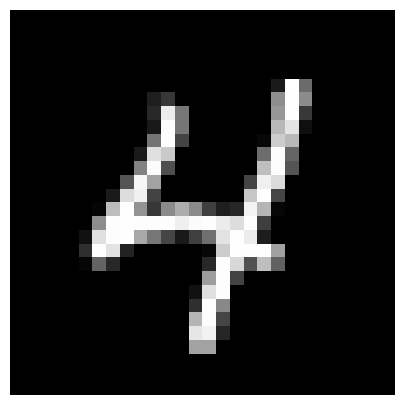

In [ ]:
rnd_idx = np.random.randint(len(y_test))

print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Equations


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Helper functions

#### Creat Mini batches

In [ ]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1

    Creates mini batches from the datasets where y and x have the same sizes and mix it up 
    to have different combinations in the new x and y 
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size + 1))

## Nuestra clase Linear, ReLU y Sequential

class to convert the np array to a np tensor

In [94]:
class np_tensor(np.ndarray): pass

creates a numpy array as a 


creates a numpy tensor from a as b

In [95]:
a = np.array([0, 0])
b = a.view(np_tensor)

a is a numpy array

In [96]:
type(a)

numpy.ndarray

b is a numpy tensor

In [97]:
type(b)

__main__.np_tensor

a and b are have the same values

In [ ]:
a == b

np_tensor([ True,  True])

a numpy array is not the same as a numpy tensor

In [ ]:
a is b

False

###  Clase Linear

Creates the fully connected layer of the neural network that adds the layer parameters

In [100]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    
    

### Clase ReLU

Creates the Rectified Linear Unit activation function

In [ ]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

Creates the organization of the multiple layers

In [102]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))            

### Cost Function

In [ ]:
def softmaxXEntropy(x, y):
    """
    Calculates the softmax entropy loss 
    """
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Loop de entrenamiento

In [ ]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    """
    creates a double iteration where it iterates for every mini batch
    for every epoch, having multiple trainings in total for every epoch
    """
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [ ]:
def accuracy(x, y, mb_size):
    """
    creates two counting variables for the correct predictions and total predictions
    it creates a lopp for the mini batches and the x and y datasets
    evrytime it makes a prediction it sums a +1 for each variables
    and returns the accuracy that is the division between the correct and total predictions
    """
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

model inputs that include the previous formulas with the input, outputs and hyperparameters

In [ ]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20

displays the cost and accuracy based on the number of epochs

In [ ]:
train(model, epochs, mb_size, learning_rate)

costo: 0.3162099667598945, accuracy: 0.9187456166716762
costo: 0.21954275899832135, accuracy: 0.9352770263500652
costo: 0.20433033262677242, accuracy: 0.946899108305781
costo: 0.2589514698549462, accuracy: 0.9511071034966436
costo: 0.23235651786344597, accuracy: 0.9549143372407575
costo: 0.16747907220911631, accuracy: 0.9578198577296864
costo: 0.1052879865599707, accuracy: 0.9607253782186154
costo: 0.09301115552608133, accuracy: 0.9639314697926059
costo: 0.10918976652955531, accuracy: 0.9638312794309187
costo: 0.11253189307195219, accuracy: 0.9645326119627292
costo: 0.09590986215505931, accuracy: 0.9661356577497244
costo: 0.1454255799551325, accuracy: 0.9668369902815349
costo: 0.08044788359812634, accuracy: 0.9678388938984069
costo: 0.11571575360806821, accuracy: 0.9696423204087766
costo: 0.0655420710679771, accuracy: 0.9691413686003406
costo: 0.11906606781376235, accuracy: 0.9691413686003406
costo: 0.054460470552865924, accuracy: 0.9700430818555255
costo: 0.06686706295300346, accuracy

calculates the total accuracy of the model

In [ ]:
print(f"Accuracy: %{accuracy(x_test, y_test, mb_size) * 100}")

Accuracy: %97.03436529405872


calculates a random number


displays the random number 


prediction of the random number


print the real and predicted value

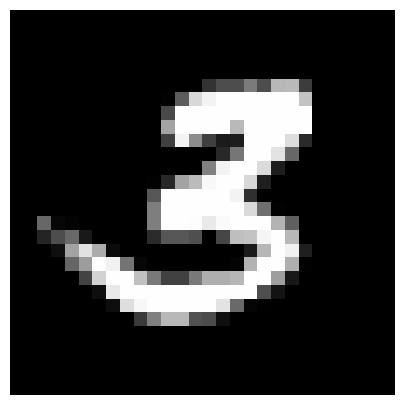

el valor predicho es: 3, el valor real es:3


In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}, el valor real es:{y_test[idx][0]}')